In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc,os,sys
import re

from sklearn import metrics, preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA, KernelPCA
from sklearn.cluster import KMeans
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

sns.set_style('darkgrid')

pd.options.display.float_format = '{:,.3f}'.format

In [3]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        #else:
            #df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB --> {:.2f} MB (Decreased by {:.1f}%)'.format(
        start_mem, end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
train_id = pd.read_csv('_input/train_identity.csv')
train_trn = pd.read_csv('_input/train_transaction.csv')
test_id = pd.read_csv('_input/test_identity.csv')
test_trn = pd.read_csv('_input/test_transaction.csv')

id_cols = train_id.columns.to_list()
trn_cols = train_trn.drop('isFraud', axis=1).columns.tolist()

X_train = pd.merge(train_trn[['isFraud'] + trn_cols], train_id[id_cols], how='left')
X_train = reduce_mem_usage(X_train)

X_test = pd.merge(test_trn[trn_cols], test_id[id_cols], how='left')
X_test = reduce_mem_usage(X_test)

X_train_id = X_train.pop('TransactionID')
X_test_id = X_test.pop('TransactionID')

del train_id, train_trn, test_id, test_trn
gc.collect()

all_data = X_train.append(X_test, sort=False).reset_index(drop=True)

Memory usage of dataframe is 1959.00 MB --> 650.00 MB (Decreased by 66.0%)
Memory usage of dataframe is 1677.00 MB --> 565.00 MB (Decreased by 66.0%)


In [8]:
all_data = X_train.append(X_test, sort=False).reset_index(drop=True)

(590540, 433)

In [11]:
vcols = ['V%d' % i for i in range(1, 340)]

sc = preprocessing.MinMaxScaler()
pca = PCA(n_components=2)

vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

all_data['_vcol_pca0'] = vcol_pca[:, 0]
all_data['_vcol_pca1'] = vcol_pca[:, 1]
all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

all_data.drop(vcols, axis=1, inplace=True)

In [12]:
import datetime

START_DATE = '2017-12-01'
startdate = datetime.datetime.strptime(START_DATE, "%Y-%m-%d")
all_data['Date'] = all_data['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds=x)))
all_data['_weekday'] = all_data['Date'].dt.dayofweek
all_data['_hour'] = all_data['Date'].dt.hour
all_data['_day'] = all_data['Date'].dt.day

all_data['_weekday'] = all_data['_weekday'].astype(str)
all_data['_hour'] = all_data['_hour'].astype(str)
all_data['_weekday__hour'] = all_data['_weekday'] + all_data['_hour']

cnt_day = all_data['_day'].value_counts()
cnt_day = cnt_day / cnt_day.mean()
all_data['_count_rate'] = all_data['_day'].map(cnt_day.to_dict())

all_data.drop(['TransactionDT','Date','_day'], axis=1, inplace=True)

In [13]:
all_data['_P_emaildomain__addr1'] = all_data['P_emaildomain'] + '__' + all_data['addr1'].astype(str)
all_data['_card1__card2'] = all_data['card1'].astype(str) + '__' + all_data['card2'].astype(str)
all_data['_card1__addr1'] = all_data['card1'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card2__addr1'] = all_data['card2'].astype(str) + '__' + all_data['addr1'].astype(str)
all_data['_card12__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)
all_data['_card_all__addr1'] = all_data['_card1__card2'] + '__' + all_data['addr1'].astype(str)

In [14]:
all_data['_amount_decimal'] = ((all_data['TransactionAmt'] - all_data['TransactionAmt'].astype(int)) * 1000).astype(int)
all_data['_amount_decimal_len'] = all_data['TransactionAmt'].apply(lambda x: len(re.sub('0+$', '', str(x)).split('.')[1]))
all_data['_amount_fraction'] = all_data['TransactionAmt'].apply(lambda x: float('0.'+re.sub('^[0-9]|\.|0+$', '', str(x))))
all_data[['TransactionAmt','_amount_decimal','_amount_decimal_len','_amount_fraction']].head(10)

,TransactionAmt,_amount_decimal,_amount_decimal_len,_amount_fraction
0,68.500,500,1,0.850
1,29.000,0,0,0.900
2,59.000,0,0,0.900
3,50.000,0,0,0.000
4,50.000,0,0,0.000
5,49.000,0,0,0.900
6,159.000,0,0,0.590
7,422.500,500,1,0.225
8,15.000,0,0,0.500
9,117.000,0,0,0.170


In [39]:
cols = ['ProductCD', 'card1', 'card2', 'card5', 'card6', 'P_emaildomain', '_card_all__addr1']

# amount mean&std
for f in cols:
    all_data['_amount_mean_{}'.format(f)] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
    all_data['_amount_std_{}'.format(f)] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
    all_data['_amount_pct_{}'.format(f)] = (all_data['TransactionAmt'] - all_data['_amount_mean_{}'.format(f)]) / all_data['_amount_std_{}'.format(f)]
#     all_data[f'_amount_mean_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
#     all_data[f'_amount_std_{f}'] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
#     all_data[f'_amount_pct_{f}'] = (all_data['TransactionAmt'] - all_data[f'_amount_mean_{f}']) / all_data[f'_amount_std_{f}']


# freq encoding
for f in cols:
    vc = all_data[f].value_counts(dropna=False)
    all_data['_count_{}'.format(f)] = all_data[f].map(vc)
    

In [40]:
print('features :', all_data.shape[1])

('features :', 137)


In [70]:
_='''
cat_cols = ['ProductCD','card1','card2','card3','card4','card5','card6','addr1','addr2','P_emaildomain','R_emaildomain',
            'M1','M2','M3','M4','M5','M6','M7','M8','M9','DeviceType','DeviceInfo'] + [f'id_{i}' for i in range(12,39)]
'''

cat_cols = ['id_{:02d}'.format(i) for i in range(12, 39)]
for i in cat_cols:
    if i in all_data.columns:
        all_data[i] = all_data[i].astype(str)
        all_data[i].fillna('unknown', inplace=True)

enc_cols = []
for i, t in all_data.loc[:, all_data.columns != 'isFraud'].dtypes.iteritems():
    if t == object:
        enc_cols.append(i)
        #df = pd.concat([df, pd.get_dummies(df[i].astype(str), prefix=i)], axis=1)
        #df.drop(i, axis=1, inplace=True)
        all_data[i] = pd.factorize(all_data[i])[0]
        #all_data[i] = all_data[i].astype('category')
print(enc_cols)

['ProductCD', 'card4', 'card6', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', '_weekday', '_hour', '_weekday__hour', '_P_emaildomain__addr1', '_card1__card2', '_card1__addr1', '_card2__addr1', '_card12__addr1', '_card_all__addr1']


In [74]:
X_train = all_data[all_data['isFraud'].notnull()]

In [75]:
print(all_data.shape)
print(X_train.shape)

(1097231, 137)
(590540, 137)


In [76]:
X_test = all_data[all_data['isFraud'].isnull()].drop('isFraud', axis=1)
print X_test.shape

(506691, 136)


In [77]:
Y_train = X_train.pop('isFraud')
print(X_train.shape)
print(Y_train.shape)

(590540, 136)
(590540,)


In [90]:
%%time

import lightgbm as lgb

params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85,
        'n_estimators': 3000
       }

oof_preds = np.zeros(X_train.shape[0])
sub_preds = np.zeros(X_test.shape[0])

clf = lgb.LGBMClassifier(**params)
clf.fit(X_train, Y_train)
oof_preds = clf.predict_proba(X_train, num_iteration=clf.best_iteration_)[:,1]
sub_preds = clf.predict_proba(X_test, num_iteration=clf.best_iteration_)[:,1]

CPU times: user 1h 37min 28s, sys: 36.1 s, total: 1h 38min 4s
Wall time: 25min 23s


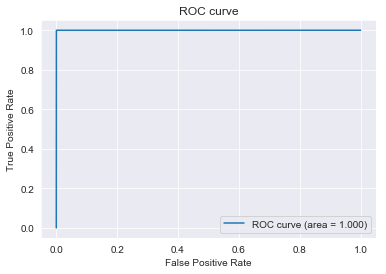

In [91]:
fpr, tpr, thresholds = metrics.roc_curve(Y_train, oof_preds)
auc = metrics.auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %.3f)' % auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

plt.show()


In [109]:
def get_importances(clf):
    feature_importance = clf.feature_importances_
    feature_importance = 100 * feature_importance / feature_importance.max()

    sorted_idx = np.argsort(feature_importance)
    sorted_idx = sorted_idx[-50:]
    pos = np.arange(sorted_idx.shape[0]) + .5

    plt.figure(figsize=(10,12))
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, X_train.columns[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()

    data = pd.DataFrame(feature_importance[sorted_idx], index=X_train.columns[sorted_idx])
    return data

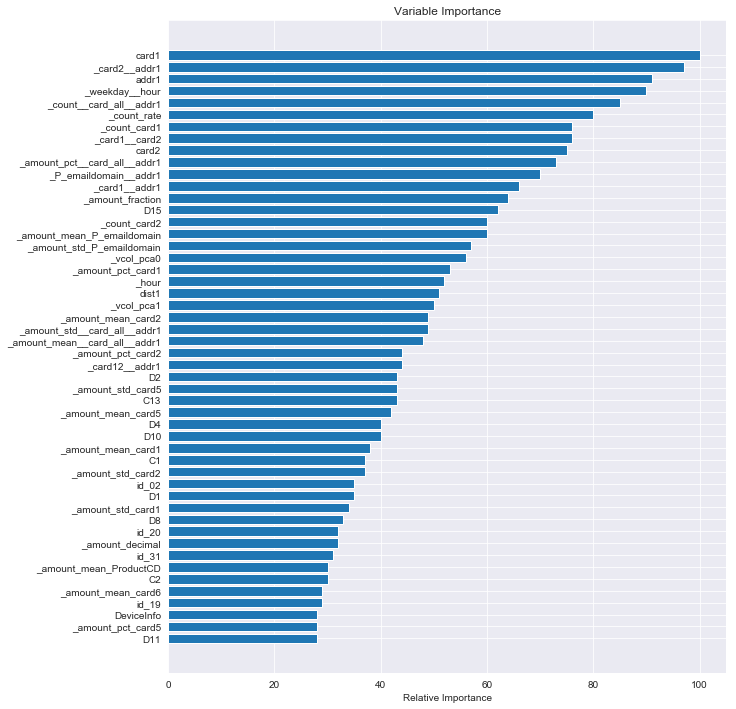

In [111]:
_ = get_importances(clf)

In [98]:
def fast_auc(y_true, y_prob):
    y_true = np.asarray(y_true)
    y_true = y_true[np.argsort(y_prob)]
    nfalse = 0.
    auc = 0.
    n = len(y_true)
    for i in range(n):
        y_i = y_true[i]
        nfalse += (1 - y_i)
        auc += y_i * nfalse
    auc /= (nfalse * (n - nfalse))
    return auc

In [99]:
fast_auc(Y_train, oof_preds)

0.9999994716938135

In [106]:
X_train[['addr1', 'addr2']].head()

,addr1,addr2
0,315.000,87.000
1,325.000,87.000
2,330.000,87.000
3,476.000,87.000
4,420.000,87.000


In [143]:
import time

def mysub(sub_id, sub_preds):
    dirname = '_output/'
    timestr = time.strftime('%Y%m%d-%H%M%S')
    filename = dirname + 'submission_' + timestr + '.csv'

    submission = pd.DataFrame()
    submission['TransactionID'] = sub_id
    submission['isFraud'] = sub_preds
    submission.to_csv(filename, index=False)
    return 


In [134]:
def eval_auc (preds, dtrain):
    labels = dtrain.get_label()    
    return 'auc', fast_auc(labels, preds), True


In [184]:
def cross_validate_lgb(param, x_train, y_train, x_test, kf,  
                       num_boost_round, 
                       fname='submission', nseed=1, verbose_eval=1,
                       featimp=False, save_pred=False,
                       use_auc=True,
                       early_stopping_rounds=150,
                       use_all_folds=True,
                       ):
    
    if save_pred:
        now = datetime.datetime.now()
        now = str(now.strftime('%Y-%m-%d-%H-%M-%S'))
        print 'started at:', now
        print 'num bagging seeds:', nseed
        fname = '_output/'+fname+'_'+now
        print 'data size:', x_train.shape, x_test.shape
        
    
    nfold = kf.n_splits
    print 'nfold:', nfold
        
    val_pred = np.zeros((x_train.shape[0], nseed))
    test_pred = np.zeros((x_test.shape[0], nfold * nseed))
        
    print 'num features:', x_train.shape[1]
    
    d_train = lgb.Dataset(x_train.values, label=y_train)
    if use_auc:
        metric = 'auc'
    else:
        metric = None
    history = lgb.cv(params, d_train, num_boost_round=num_boost_round, 
                     folds=kf, metrics=metric, fobj=None,
                     early_stopping_rounds=early_stopping_rounds, 
                     verbose_eval=verbose_eval, show_stdv=True, seed=0)
    if use_auc:
        best_round = np.argmax(history['auc-mean'])
    else:
        best_round = np.argmin(history['binary_logloss-mean'])
    print 'best_round:', best_round
    if best_round == 0:
        best_round = 1
        
    bsts = []
    for i, (train_index, test_index) in enumerate(kf.split(x_train, y_train)):
        print 'train fold', i,
        x_train_kf, x_test_kf = x_train.loc[train_index,:].copy(), x_train.loc[test_index,:].copy()
        y_train_kf, y_test_kf = y_train[train_index], y_train[test_index]

        d_train_kf = lgb.Dataset(x_train_kf, label=y_train_kf)
        d_test_kf = lgb.Dataset(x_test_kf, label=y_test_kf)
        
        train_fold_pred = 0
        
        feval = None
        if use_auc:
            feval=eval_auc
        for seed in range(nseed):
            param['seed'] = seed
            
            bst = lgb.train(param, d_train_kf, num_boost_round=best_round,
                            verbose_eval=None,
                            early_stopping_rounds=None, 
                            )

            bsts.append(bst)
            pred = bst.predict(x_test_kf)
            val_pred[test_index, seed] = (pred)
            pred = bst.predict(x_test)
            test_pred[:, i*nseed + seed] = (pred)
            train_fold_pred = train_fold_pred + bst.predict(x_train_kf)
            print '.',
            
        train_fold_pred /= nseed
        print 'train auc: %0.5f' % fast_auc(y_train_kf, train_fold_pred),
        val_fold_pred = np.mean(val_pred[test_index,:], axis=1)  
        print 'val auc: %0.5f' % fast_auc(y_test_kf, val_fold_pred)
        del d_train_kf
        del d_test_kf
        gc.collect()
        if featimp:
            importances = get_importances(bsts)
            plt.show()
        else:
            importances = None
        if use_all_folds == False:
            break
    
    
    print 'saving raw train prediction to:', fname+'_train.npy'
    np.save(fname+'_train.npy', val_pred)
    print 'saving raw test prediction to:', fname+'_test.npy'
    np.save(fname+'_test.npy', test_pred)
    
    epsilon = 1e-6

    train_expit = (val_pred + epsilon - val_pred.ravel().min())
    test_expit = (test_pred + epsilon - test_pred.ravel().min())
    train_expit /= (epsilon + train_expit.ravel().max())
    test_expit /= (epsilon + test_expit.ravel().max())
    
    train_pred_mean = np.mean(train_expit, axis=1)
    test_pred_mean = np.mean(test_expit, axis=1)        
    print 'cv       mean auc:%0.5f' % fast_auc(y_train, train_pred_mean)
    print 'saving mean test prediction ...'
    mysub(X_test_id, test_pred.mean(axis=1))

    if featimp:
        importances = get_importances(bsts)
    else:
        importances = None

    return importances, val_pred, test_pred, bsts, fname


In [127]:
kf = StratifiedKFold(5, shuffle=True, random_state=7)

In [130]:
params={'learning_rate': 0.01,
        'objective': 'binary',
        'metric': 'auc',
        'num_threads': -1,
        'num_leaves': 256,
        'verbose': 1,
        'random_state': 42,
        'bagging_fraction': 1,
        'feature_fraction': 0.85
       }

In [129]:
X_test.shape

(506691, 136)

In [136]:
(importances_reglinear, train_pred_reglinear, test_pred_reglinear, bsts, fname_save)
= cross_validate_lgb(params, X_train, Y_train, X_test, kf,  
                     num_boost_round=3000, 
                     verbose_eval=100,
                     featimp=False, save_pred=True,
                     use_auc=True,
                     early_stopping_rounds=150
                     )

started at: 2019-09-30-17-30-16
num bagging seeds: 1
(590540, 136) (506691, 136)
nfold 5
num features: 136
[100]	cv_agg's auc: 0.916853 + 0.00298893
[200]	cv_agg's auc: 0.938651 + 0.00245428
[300]	cv_agg's auc: 0.950914 + 0.00185262
[400]	cv_agg's auc: 0.958642 + 0.00168121
[500]	cv_agg's auc: 0.963191 + 0.00162154
[600]	cv_agg's auc: 0.965952 + 0.00160668
[700]	cv_agg's auc: 0.967645 + 0.00168477
[800]	cv_agg's auc: 0.968977 + 0.00174784
[900]	cv_agg's auc: 0.969973 + 0.00175295
[1000]	cv_agg's auc: 0.970819 + 0.00171146
[1100]	cv_agg's auc: 0.971533 + 0.00168587
[1200]	cv_agg's auc: 0.972175 + 0.0016138
[1300]	cv_agg's auc: 0.972763 + 0.00155297
[1400]	cv_agg's auc: 0.973224 + 0.00149501
[1500]	cv_agg's auc: 0.973647 + 0.00146789
[1600]	cv_agg's auc: 0.974016 + 0.00143024
[1700]	cv_agg's auc: 0.97437 + 0.00142256
[1800]	cv_agg's auc: 0.974698 + 0.00143554
[1900]	cv_agg's auc: 0.974929 + 0.00142628
[2000]	cv_agg's auc: 0.975184 + 0.00141259
[2100]	cv_agg's auc: 0.975365 + 0.001417
[22

(None, array([[0.00736287],
        [0.00176782],
        [0.00133708],
        ...,
        [0.00062533],
        [0.00490484],
        [0.00223512]]), array([[4.57001837e-05, 3.81059995e-05, 2.55988638e-05, 3.94766998e-05,
         3.42642070e-05],
        [2.39457302e-04, 1.68437239e-04, 1.55127461e-04, 3.48715415e-04,
         7.09875891e-04],
        [1.06423001e-04, 1.99531106e-04, 1.88613484e-04, 2.72743792e-04,
         1.30616164e-04],
        ...,
        [2.05005887e-03, 1.94377529e-03, 4.11009631e-03, 2.82361748e-03,
         2.25511622e-03],
        [3.28091163e-03, 1.35384294e-03, 3.39630113e-03, 1.76510399e-03,
         1.29444257e-03],
        [1.61673678e-03, 1.03142362e-03, 5.39924119e-04, 7.42636037e-04,
         1.17326492e-03]]), [<lightgbm.basic.Booster at 0x11a075090>,
  <lightgbm.basic.Booster at 0x11a075750>], '_output/submission_2019-09-30-17-30-16')

In [138]:
preds = np.load('_output/submission_2019-09-30-17-30-16_test.npy')

In [142]:
test_preds = preds.mean(axis=1)
test_preds.shape

(506691,)

In [145]:
mysub(X_test_id, test_preds)

In [156]:
cols = ['dist1', 'dist2']

print X_train[cols].head(10), '\n'
print X_train[cols].dtypes


    dist1  dist2
0  19.000    nan
1     nan    nan
2 287.000    nan
3     nan    nan
4     nan    nan
5  36.000    nan
6   0.000    nan
7     nan    nan
8     nan    nan
9  19.000    nan
dist1    float16
dist2    float16
dtype: object


In [157]:
X_train['_card_n'] = X_train['card1'].astype(str) + '__' + X_train['card2'].astype(str) + '__' + X_train['card3'].astype(str) + '__' + X_train['card5'].astype(str)
X_test['_card_n'] = X_test['card1'].astype(str) + '__' + X_test['card2'].astype(str) + '__' + X_test['card3'].astype(str) + '__' + X_test['card5'].astype(str)

In [158]:
cols = ['_card_n']

# amount mean&std
# for f in cols:
#     all_data['_amount_mean_{}'.format(f)] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('mean')
#     all_data['_amount_std_{}'.format(f)] = all_data['TransactionAmt'] / all_data.groupby([f])['TransactionAmt'].transform('std')
#     all_data['_amount_pct_{}'.format(f)] = (all_data['TransactionAmt'] - all_data['_amount_mean_{}'.format(f)]) / all_data['_amount_std_{}'.format(f)]


# freq encoding
for f in cols:
    vc = X_train[f].value_counts(dropna=False)
    X_train['_count_{}'.format(f)] = X_train[f].map(vc)
    X_test['_count_{}'.format(f)] = X_test[f].map(vc) 
    


In [175]:
df = X_train['_card_n'].append(X_test['_card_n'])
df = pd.factorize(df)[0]
X_train['_card_n'] = df[:len(X_train)]
X_test['_card_n'] = df[len(X_train):]

In [183]:
(importances_reglinear, train_pred_reglinear, test_pred_reglinear, bsts, fname_save)= cross_validate_lgb(params, X_train, Y_train, X_test, kf,  
                     num_boost_round=3000, 
                     verbose_eval=100,
                     featimp=False, save_pred=True,
                     use_auc=True,
                     early_stopping_rounds=150
                     )

started at: 2019-10-01-07-48-28
num bagging seeds: 1
data size: (590540, 138) (506691, 139)
nfold: 5
num features: 138
[100]	cv_agg's auc: 0.918142 + 0.00326373
[200]	cv_agg's auc: 0.938791 + 0.00227027
[300]	cv_agg's auc: 0.951133 + 0.00139617
[400]	cv_agg's auc: 0.95903 + 0.00133426
[500]	cv_agg's auc: 0.963421 + 0.00133985
[600]	cv_agg's auc: 0.966125 + 0.00135139
[700]	cv_agg's auc: 0.967843 + 0.00135223
[800]	cv_agg's auc: 0.969153 + 0.0014059
[900]	cv_agg's auc: 0.970183 + 0.00143371
[1000]	cv_agg's auc: 0.971024 + 0.00144205
[1100]	cv_agg's auc: 0.9717 + 0.00139779
[1200]	cv_agg's auc: 0.972319 + 0.00135776
[1300]	cv_agg's auc: 0.972872 + 0.00134488
[1400]	cv_agg's auc: 0.973363 + 0.00132062
[1500]	cv_agg's auc: 0.973802 + 0.00130464
[1600]	cv_agg's auc: 0.974215 + 0.00127528
[1700]	cv_agg's auc: 0.974516 + 0.00126304
[1800]	cv_agg's auc: 0.974804 + 0.00125056
[1900]	cv_agg's auc: 0.975043 + 0.00128151
[2000]	cv_agg's auc: 0.975269 + 0.00133459
[2100]	cv_agg's auc: 0.975453 + 0.

In [ ]:
UTC -3 to UTC +5

In [185]:
(importances_reglinear, train_pred_reglinear, test_pred_reglinear, bsts, fname_save)= cross_validate_lgb(params, X_train, Y_train, X_test, kf,  
                     num_boost_round=5000, 
                     verbose_eval=200,
                     featimp=False, save_pred=True,
                     use_auc=True,
                     early_stopping_rounds=150
                     )

started at: 2019-10-01-20-33-50
num bagging seeds: 1
data size: (590540, 138) (506691, 139)
nfold: 5
num features: 138
[200]	cv_agg's auc: 0.938791 + 0.00227027
[400]	cv_agg's auc: 0.95903 + 0.00133426
[600]	cv_agg's auc: 0.966125 + 0.00135139
[800]	cv_agg's auc: 0.969153 + 0.0014059
[1000]	cv_agg's auc: 0.971024 + 0.00144205
[1200]	cv_agg's auc: 0.972319 + 0.00135776
[1400]	cv_agg's auc: 0.973363 + 0.00132062
[1600]	cv_agg's auc: 0.974215 + 0.00127528
[1800]	cv_agg's auc: 0.974804 + 0.00125056
[2000]	cv_agg's auc: 0.975269 + 0.00133459
[2200]	cv_agg's auc: 0.975632 + 0.00134665
[2400]	cv_agg's auc: 0.975905 + 0.00137005
[2600]	cv_agg's auc: 0.97611 + 0.00131166
[2800]	cv_agg's auc: 0.976284 + 0.0012646
[3000]	cv_agg's auc: 0.976402 + 0.00124701
[3200]	cv_agg's auc: 0.976481 + 0.00120186
[3400]	cv_agg's auc: 0.976552 + 0.00121137
[3600]	cv_agg's auc: 0.976619 + 0.0012067
[3800]	cv_agg's auc: 0.976643 + 0.00125521
[4000]	cv_agg's auc: 0.976722 + 0.00125624
[4200]	cv_agg's auc: 0.976728 